In [1]:
from mpi4py import MPI
import ast
# torch
import torch
import torch.nn as nn

import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

# quimb
import quimb.tensor as qtn
import symmray as sr
import autoray as ar
from autoray import do

from vmc_torch.fermion_utils import *

/home/sijingdu/anaconda3/envs/vmc_torch/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/sijingdu/anaconda3/envs/vmc_torch/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


## U1 to Z2 cannot avoid the dynamic shapes in TNS

In [2]:
Lx = 6
Ly = 6
D = 4
symmetry = 'U1'
N_f = int(4*4/2)-2
# Create a random PEPS
peps, parity_config_u1 = generate_random_fpeps(Lx, Ly, D, seed=2, symmetry=symmetry, Nf=N_f)

# Create a random configuration
random_conf = np.zeros(Lx*Ly)
random_conf[:N_f] = 1
np.random.seed(1)
np.random.shuffle(random_conf)

t = 1.0
V = 4.0
mu = 0.0
edges = qtn.edges_2d_square(Lx, Ly)
site_info = sr.utils.parse_edges_to_site_info(
    edges,
    D,
    phys_dim=2,
    site_ind_id="k{},{}",
    site_tag_id="I{},{}",
)
terms = {
    (sitea, siteb): sr.fermi_hubbard_spinless_local_array(
        t=t, V=V, mu=mu,
        symmetry=symmetry,
        coordinations=(
            site_info[sitea]['coordination'],
            site_info[siteb]['coordination'],
        ),
    ).fuse((0, 1), (2, 3))
    for (sitea, siteb) in peps.gen_bond_coos()
}
ham = qtn.LocalHam2D(Lx, Ly, terms)
su_u1 = qtn.SimpleUpdateGen(peps, ham, compute_energy_per_site=True,D=D, compute_energy_opts={"max_distance":1}, gate_opts={'cutoff':1e-10})
su_u1.evolve(10, 0.3)
# su_u1.evolve(50, 0.1)
peps_U1 = su_u1.state

100%|##########| 10/10 [00:02<00:00,  4.12it/s]/home/sijingdu/anaconda3/envs/vmc_torch/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `baytune (btb)`, `chocolate`, `nevergrad` or `skopt` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
n=10, tau=0.3000, energy~-0.413470: 100%|##########| 10/10 [00:03<00:00,  2.78it/s]


In [3]:
Lx = 6
Ly = 6
D = 4
symmetry = 'Z2'
N_f = int(4*4/2)-2
# Create a random PEPS
peps, parity_config_z2 = generate_random_fpeps(Lx, Ly, D, seed=2, symmetry=symmetry, Nf=N_f)

# Create a random configuration
random_conf = np.zeros(Lx*Ly)
random_conf[:N_f] = 1
np.random.seed(1)
np.random.shuffle(random_conf)

t = 1.0
V = 4.0
mu = 0.0
edges = qtn.edges_2d_square(Lx, Ly)
site_info = sr.utils.parse_edges_to_site_info(
    edges,
    D,
    phys_dim=2,
    site_ind_id="k{},{}",
    site_tag_id="I{},{}",
)
terms = {
    (sitea, siteb): sr.fermi_hubbard_spinless_local_array(
        t=t, V=V, mu=mu,
        symmetry=symmetry,
        coordinations=(
            site_info[sitea]['coordination'],
            site_info[siteb]['coordination'],
        ),
    ).fuse((0, 1), (2, 3))
    for (sitea, siteb) in peps.gen_bond_coos()
}
ham = qtn.LocalHam2D(Lx, Ly, terms)
su_z2 = qtn.SimpleUpdateGen(peps, ham, compute_energy_per_site=True,D=D, compute_energy_opts={"max_distance":1}, gate_opts={'cutoff':1e-10})
su_z2.evolve(5, 0.3)
# su_z2.evolve(50, 0.1)
peps_Z2 = su_z2.state

n=5, tau=0.3000, energy~-0.225428: 100%|##########| 5/5 [00:01<00:00,  3.49it/s]


In [4]:
peps_Z2.arrays[4].indices

(BlockIndex(chargemap={0: 2, 1: 2}, dual=True),
 BlockIndex(chargemap={0: 2, 1: 2}, dual=False),
 BlockIndex(chargemap={0: 2, 1: 2}, dual=False),
 BlockIndex(chargemap={0: 1, 1: 1}, dual=False))

In [5]:
peps_U1.arrays[5].indices

(BlockIndex(chargemap={-1: 1, 0: 2, 1: 1}, dual=True),
 BlockIndex(chargemap={-1: 1, 0: 2, 1: 1}, dual=False),
 BlockIndex(chargemap={0: 1, 1: 1}, dual=False))

In [6]:
peps_U1.arrays[5].oddpos + peps_U1.arrays[4].oddpos

(8-,)

In [7]:
from quimb.utils import oset
test_ts = peps_U1.tensors[5]
test_ts_arr = test_ts.data
left_inds = oset(test_ts.inds[:2])
right_inds = oset(test_ts.inds) - oset(left_inds)
TT = test_ts.transpose(*left_inds, *right_inds)
# TT.data, TT.data.indices
left_dims = TT.shape[: len(left_inds)]
right_dims = TT.shape[len(left_inds) :]
TT_data_fused = TT.data.reshape((prod(left_dims), prod(right_dims)))
TT_data_fused.indices

(BlockIndex(chargemap={0: 6, 1: 4}, dual=True, subinfo=SubIndexInfo(indices=(BlockIndex(chargemap={-1: 1, 0: 2, 1: 1}, dual=True), BlockIndex(chargemap={-1: 1, 0: 2, 1: 1}, dual=False)), extents={0: {(-1, -1): 1, (0, 0): 4, (1, 1): 1}, 1: {(0, -1): 2, (1, 0): 2}})),
 BlockIndex(chargemap={0: 1, 1: 1}, dual=False))

In [8]:
def calc_reshape_args(shape, newshape, subsizes, squeeze=True):
    # tracks position in input shape
    i = 0
    # tracks position in output shape
    j = 0
    # tracks position in post-fuse / pre-expand shape
    k = 0

    ndim_old = len(shape)
    ndim_new = len(newshape)

    term = []  # dnyamically updated labelled dimensions
    axs_squeeze = []
    unfuse_sizes = {}
    fuse_sizes = {}
    axs_expand = []
    any_singleton = False
    any_fused = False

    while i < ndim_old and j < ndim_new:
        di = shape[i]
        dj = newshape[j]

        if subsizes[i] is not None and subsizes[i][0] == dj and j != ndim_new - 1 and subsizes[i][1] == newshape[j + 1]:
            # unfuse, check first
            label = f"u{len(unfuse_sizes)}"
            s = 0
            for ds in subsizes[i]:
                dj = newshape[j]
                if ds != dj:
                    raise ValueError("Shape mismatch for unfuse.")
                s += 1
                j += 1
                k += 1
            unfuse_sizes[label] = s
            term.append(label)
            i += 1
        elif di == dj:
            # output dimension already
            term.append("o")
            i += 1
            j += 1
            k += 1
        elif di == 1:
            # have to handle squeezed dimensions after unfusing
            term.append("s")
            axs_squeeze.append(i)
            any_singleton = True
            i += 1
        elif dj == 1:
            # record expansion location relative to *post* fuse shape
            axs_expand.append(k)
            j += 1
        elif di < dj:
            # need to fuse
            label = f"g{len(fuse_sizes)}"
            term.append(label)
            s = 1
            i += 1
            while di < dj:
                di *= shape[i]
                term.append(label)
                i += 1
                s += 1
            if di != dj:
                raise ValueError("Shape mismatch for fuse.")
            fuse_sizes[label] = s
            any_fused = True
            j += 1
            k += 1
        else:
            raise ValueError("Shape mismatch.")

    # check trailing dimensions, which should be size 1
    for i in range(i, ndim_old):
        any_singleton = True
        term.append("s")
    for j in range(j, ndim_new):
        axs_expand.append(k)

    # first we handle unfusings
    axs_unfuse = []
    for label, s in unfuse_sizes.items():
        ax = term.index(label)
        axs_unfuse.append(ax)
        term = term[:ax] + ["o"] * s + term[ax + 1 :]

    # handle squeezes by converting them into fuse groups
    if any_singleton:
        i = 0
        label = term[i]
        if label == "s":
            # if we have squeeze axes on left, we have to group into right
            while label == "s":
                i += 1
                label = term[i]

            if label[0] == "g":
                # adjacent to existing group
                g = label
            elif label == "o":
                # or new group
                g = f"g{len(fuse_sizes)}"
                term[i] = g
                fuse_sizes[g] = 1

            # mark all axs up to this point
            for j in range(0, i):
                fuse_sizes[g] += 1
                term[j] = g

        # process rest of term, now preferring grouping into left
        i += 1
        while i < len(term):
            label = term[i]
            if label == "s":
                left = term[i - 1]
                if left[0] == "g":
                    g = left
                elif left == "o":
                    g = f"g{len(fuse_sizes)}"
                    term[i - 1] = g
                    fuse_sizes[g] = 1

                # update any right block of squeeze axs to g
                while label == "s":
                    term[i] = g
                    fuse_sizes[g] += 1
                    i += 1
                    if i == len(term):
                        break
                    label = term[i]
            i += 1

    # now we handle fusing
    axs_fuse = []
    if any_fused or any_singleton:
        # complexity here is we want to simulteneously fuse adjacent groups for
        # efficiency, but also need to handle non-adjacent groups
        current_groups = []
        i = 0
        while i < len(term):
            label = term[i]
            if label not in fuse_sizes:
                if current_groups:
                    # start of groups
                    i0 = i - sum(map(len, current_groups))
                    ng = len(current_groups)
                    term = term[:i0] + ["o"] * ng + term[i:]
                    axs_fuse.append(tuple(current_groups))
                    current_groups = []
                    # rewind to end of new group(s)
                    i = i0 + ng
                else:
                    i += 1
                continue

            s = fuse_sizes[label]
            current_groups.append(tuple(range(i, i + s)))
            i += s
        if current_groups:
            axs_fuse.append(tuple(current_groups))

    # handle expansion
    axs_expand.reverse()

    return tuple(axs_unfuse), tuple(axs_fuse), tuple(axs_expand)
calc_reshape_args((4,4,4), (16,4), (None, None, (4,4)))
# calc_reshape_args((4,4,4), (16,4), (None, None, None))
# calc_reshape_args((4,4,3), (16,3), ((4, 4), None, None))

((), (((0, 1),),), ())

In [9]:
from symmray.abelian_core import  calc_reshape_args

In [10]:
# Create a random configuration
for seed in range(1):
    random_conf = np.zeros(Lx*Ly)
    random_conf[:N_f] = 1
    np.random.seed(seed)
    np.random.shuffle(random_conf)
    print(seed)
    amp_U1 = peps_U1.get_amp(random_conf, conj=True)
    print(amp_U1.contract())
    amp_U1.contract_boundary_from_ymin_(max_bond=4, yrange=(0, amp_U1.Ly//2-2),cutoff=0.0, canonize=False)#, compress_opts={'reduced':'right'})
    amp_U1.contract_boundary_from_ymax_(max_bond=4, yrange=(amp_U1.Ly//2, amp_U1.Ly-1),cutoff=0.0, canonize=False)
    amp_U1.contract_boundary_from_ymin_(max_bond=4, yrange=(0, amp_U1.Ly//2-1),cutoff=0.0, canonize=False)
    # amp_U1_params = amp_U1.get_params()
    # amp_U1.draw()
# # shape is dynamiclly changing based on the input configuration
# for tid, blocks in amp_U1_params.items():
#     for blk, data in blocks.items():
#         print(data.shape)

0
1.7040331003839164e-07


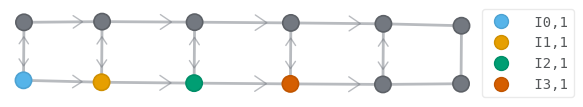

In [11]:
amp_U1.draw(color=['I0,1', 'I1,1', 'I2,1', 'I3,1'])

In [12]:
# amp_U1.compress_between('I2,1', 'I3,1', max_bond=4, cutoff=0.0, reduced='left')
ts = amp_U1.select(tags=['I2,1']).tensors[0]
ts.data.indices

(BlockIndex(chargemap={-2: 1, -1: 1, 0: 1, 1: 1}, dual=True),
 BlockIndex(chargemap={-1: 1, 0: 2, 1: 1}, dual=False),
 BlockIndex(chargemap={-1: 1, 0: 1, 1: 1, 2: 1}, dual=False))

## Consider dynamic output NN model - Transformer

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, d_model=128, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=512, dropout=0.1):
        super(TransformerModel, self).__init__()
        
        # Embedding layer for integer input sequence
        self.embedding = nn.Embedding(input_size, d_model)
        
        # Positional encoding for fixed-length sequences
        self.pos_encoder = PositionalEncoding(d_model)
        
        # Transformer layers
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout)
        
        # Linear layer for output generation (predicting floating-point values)
        self.fc_out = nn.Linear(d_model, output_size)
        
    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        
        src = src.transpose(0, 1)
        tgt = tgt.transpose(0, 1)

        # Encode source (input) sequence
        src = self.embedding(src) * torch.sqrt(torch.tensor(self.embedding.embedding_dim, dtype=torch.float32))
        src = self.pos_encoder(src)
        
        # Positional encoding for target (output) sequence
        tgt = self.pos_encoder(tgt)
        
        # Apply transformer
        output = self.transformer(src, tgt, src_mask=src_mask, tgt_mask=tgt_mask)
        
        # Predict floating-point values for each output token
        output = self.fc_out(output)

        # Transpose output to match the shape [batch_size, seq_len, output_size]
        output = output.transpose(0, 1)
        
        return output

# Example usage for binary string
input_size = 2  # Assume input integers range from 0 to 99
output_size = 1   # Each output is a single floating-point number

# Create the model
model = TransformerModel(input_size, output_size)

# # Example input: a fixed-length sequence of integers (batch size = 1, seq length = 10)
# src = torch.tensor([[1, 0, 1, 1], [1, 0, 1, 1]], dtype=torch.long)  # Shape: [batch_size, seq_len]

# # Example target (dynamic length sequence): start with a few steps (2 in this case)
# tgt = torch.zeros((2, 2, 128))  # Shape: [batch_size, seq_len,  d_model]

# # Forward pass
# output = model(src, tgt)

# print(output.shape)


/home/sijingdu/anaconda3/envs/vmc_torch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [22]:
import pyinstrument
# Create a random configuration
random_conf = np.zeros(Lx*Ly)
random_conf[:N_f] = 1
# np.random.seed(1)
np.random.shuffle(random_conf)
with pyinstrument.profile():
    amp_U1 = peps_U1.get_amp(random_conf, conj=True)
    print(amp_U1.contract())
    amp_U1.contract_boundary_from_ymin_(max_bond=8, yrange=(0, amp_U1.Ly//2-1),cutoff=0.0)
    amp_U1.contract_boundary_from_ymax_(max_bond=8, yrange=(amp_U1.Ly//2, amp_U1.Ly-1),cutoff=0.0)
    amp_U1_params, amp_U1_skeleton = qtn.pack(amp_U1)
    flattend_params = flatten_proj_params(amp_U1_params)
    vec_len = len(flattend_params)
    print(vec_len)
    random_conf = torch.tensor(random_conf, dtype=torch.int32)
    # input is the random configuration
    # src = torch.tensor([random_conf], dtype=torch.long) # Shape: [batch_size, seq_len]
    src = random_conf.unsqueeze(0)
    # target output is a vector of the shape of the flattened parameters
    tgt = torch.zeros((1, vec_len, 128)) # Shape: [batch_size, seq_len,  d_model]

    # Forward pass
    output = model(src, tgt) # shape [batch_size, seq_len, output_size]

    # concatenate the output to get the final vector of length vec_len
    output = output.view(-1)

    new_flattend_params = flattend_params + 0.01*output.detach().numpy()
    new_params = reconstruct_proj_params(new_flattend_params, amp_U1_params)

    new_amp_U1 = qtn.unpack(new_params, amp_U1_skeleton)
    print(new_amp_U1.contract())

9.672725148729228e-08
379
torch.Size([1, 36])
-6.62919670252867e-07



pyinstrument ........................................
.
.  Block at /tmp/ipykernel_7419/3205206528.py:7
.
.  0.231 <module>  ../../../../../tmp/ipykernel_7419/3205206528.py:7
.  ├─ 0.065 PEPS.contract  quimb/tensor/tensor_core.py:8396
.  │     [5 frames hidden]  functools, quimb, cotengra
.  │        0.062 wrapper  functools.py:883
.  │        └─ 0.061 tensordot_fermionic  symmray/fermionic_core.py:711
.  │           ├─ 0.041 tensordot_abelian  symmray/abelian_core.py:1997
.  │           │  └─ 0.040 _tensordot_via_fused  symmray/abelian_core.py:1942
.  │           │     ├─ 0.018 U1FermionicArray.fuse  symmray/abelian_core.py:1419
.  │           │     │  ├─ 0.007 U1FermionicArray.cached_fuse_block_info  symmray/abelian_core.py:670
.  │           │     │  │  └─ 0.005 U1FermionicArray.calc_fuse_block_info  symmray/abelian_core.py:534
.  │           │     │  ├─ 0.006 <dictcomp>  symmray/abelian_core.py:1525
.  │           │     │  │  └─ 0.006 _recurse_concat  symmray/abelian_core.py:1485
